# Clusterización

 Utilizando el set de datos que hayas utilizado en las prácticas anteriores, aplica el modelo K-Means para realizar una agrupación de la data, posteriormente realiza análisis sobre los resultados.

- Elige Set de Datos (Opiniones)

In [4]:
import pandas as pd
# Cargar el archivo Excel
file_path = 'corpus/Rest_Mex_2022_Sentiment_Analysis_Track_Train.xlsx'
df = pd.read_excel(file_path)
df.head()

,Title,Opinion,Polarity,Attraction
0,Pésimo lugar,"Piensen dos veces antes de ir a este hotel, te...",1,Hotel
1,No vayas a lugar de Eddie,Cuatro de nosotros fuimos recientemente a Eddi...,1,Restaurant
2,Mala relación calidad-precio,seguiré corta y simple: limpieza\n- bad. Tengo...,1,Hotel
3,Minusválido? ¡No te alojes aquí!,Al reservar un hotel con multipropiedad Mayan ...,1,Hotel
4,Es una porqueria no pierdan su tiempo,"No pierdan su tiempo ni dinero, venimos porque...",1,Hotel


**Preprocesa el set de datos: Aplicación de técnicas de Normalización (minúsculas, tokenización, eliminación de stopwords)**
- Funcion para preprocesamiento del texto

In [5]:
# Bibliotecas para procesamiento de texto
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


# Eliminamos valores nulos
df = df.dropna()
# Lematizador
lemmatizer = WordNetLemmatizer()
# Stopwords en español
stop_words = set(stopwords.words('spanish'))
# Creamos lista de tags a utilizar
tags = ['ADJ', 'NOUN', 'VERB']
# Cargar el modelo de spaCy para español
nlp = spacy.load("es_core_news_sm")

def normalize_text(text):
    # Tokenizar el texto
    tokens = word_tokenize(text)
    # Convertir a minúsculas
    tokens_lower = [word.lower() for word in tokens]
    # Eliminar puntuación
    tokens_no_punct = [word for word in tokens_lower if word.isalnum()]
    # Eliminar stopwords
    tokens_no_stopwords = [word for word in tokens_no_punct if word not in stop_words]
    # Unir tokens
    tokens = " ".join(tokens_no_stopwords)
    # Procesar texto con spaCy
    doc = nlp(tokens)
    # Discriminar por tags
    normalized_text = [word.lemma_ for word in doc if word.pos_ in tags]
    # normalized_text = [word.lemma_ for word in doc]
    # Unir en una sola cadena
    normalized_text = " ".join(normalized_text)

    return normalized_text

#sample_sentence = "¡Hola, Juan! ¿Cómo estás? Él está viajando en un avión a París. ¡Qué emocionante! #vacaciones"
#normalize_text(sample_sentence)


- Preprocesamiento del texto en paralelo

In [6]:
from concurrent.futures import ThreadPoolExecutor

def parallel_processing_threads(data, func):
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(func, data))
    return results

# Normaliza el dataframe en paralelo
df['Opinion'] = parallel_processing_threads(df['Opinion'], normalize_text)

# Mostrar el dataframe
df.head()

# Guardar el dataframe en un archivo CSV
df.to_csv('corpus/Rest_Mex_2022_Sentiment_Analysis_Track_Train_Normalized.csv', index=False)

**Vectoriza el dataset con Red Neuronal Doc2Vec**

In [7]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Preparar los datos
tagged_data = [TaggedDocument(words=opinion.split(), tags=[str(i)]) for i, opinion in enumerate(df['Opinion'])]

# Construir y entrenar el modelo
model = Doc2Vec(vector_size=20, window=2, min_count=1, workers=4, epochs=100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Guardar el modelo para uso futuro
model.save("doc2vec_model_cluster")

**Cargar el modelo**

In [8]:
from gensim.models.doc2vec import Doc2Vec
import numpy as np

# Cargar el dataframe normalizado
df = pd.read_csv('corpus/Rest_Mex_2022_Sentiment_Analysis_Track_Train_Normalized.csv')

# Cargar el modelo
model = Doc2Vec.load("doc2vec_model_cluster")

# Preparar los datos
vector_op = np.array([model.infer_vector(opinion.split()) for opinion in df['Opinion']])

# Dimensiones del vector
vector_op.shape

(30208, 20)

**Crear nuevo Dataframe con el vector**

In [9]:
df_vector = pd.DataFrame(vector_op)

# Eliminar valores nulos
df_vector = df_vector.dropna()

# Nombrar columnas
df_vector.columns = ['V' + str(i) for i in range(20)]

# Mostrar el dataframe
df_vector.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19
0,4.900025,-0.209575,-2.935701,-0.162088,-0.436318,-0.435943,-0.063966,1.661485,-0.155295,0.175723,2.002495,1.867570,-0.849307,0.640072,0.191621,0.692752,0.259654,0.450602,-0.814182,0.341731
1,2.456350,-2.724005,-1.760433,-0.114774,1.542853,-0.361509,0.864899,0.051149,-1.959156,-2.072782,2.152327,0.179084,-2.445225,-1.930827,-0.319622,1.264505,0.308560,-3.727610,-0.491314,-1.090011
2,0.247894,-0.948667,-0.057018,-3.032995,0.209279,-1.617944,1.613521,2.285951,-0.443820,-0.592285,-1.192362,-0.238107,0.518507,-1.243195,-0.351367,0.778716,1.475597,-1.345143,-0.942485,-3.033712
3,1.288459,-2.399776,-2.550122,-2.258828,-1.573256,2.206184,0.774097,3.158121,-1.754810,2.070841,-0.385700,2.416708,-3.263507,0.748553,-2.203670,0.579877,-1.442873,-0.955233,-0.692923,-3.742143
4,3.585984,1.489644,-1.149403,-1.409133,-1.520113,-0.171292,-0.687166,-0.783136,-0.761706,-0.868812,1.764684,-0.151695,-2.410770,0.688868,1.726721,-0.515201,0.560317,0.438784,0.083946,-2.118943


**Determina el número recomendado de clústers**

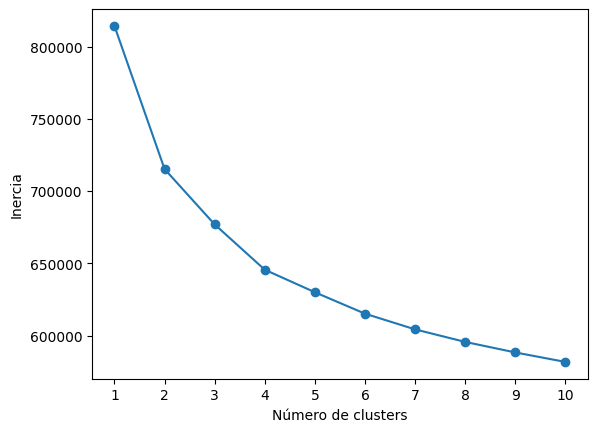

In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Lista para almacenar los valores de la inercia
inertia = []

# Lista para almacenar el número de clusters
k = []

# Iterar de 1 a 10 clusters

for i in range(1, 11):
    # Crear el modelo
    model = KMeans(n_clusters=i, random_state=42, n_init=10)
    # Entrenar el modelo
    model.fit(df_vector)
    # Almacenar el valor de la inercia
    inertia.append(model.inertia_)
    # Almacenar el número de clusters
    k.append(i)

# Graficar el método del codo
plt.plot(k, inertia, '-o')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.xticks(k)
plt.show()


**Entrenar Modelo K-means**

In [22]:
# Prepapar los datos
X = df_vector

# Crear el modelo
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# Entrenar el modelo
kmeans.fit(X)

KMeans(n_clusters=3, n_init=10, random_state=42)

**Evaluamos el modelo con metricas de Silueta y Calinski harabasz**

In [23]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

# Almacenar las etiquetas
ymeans = kmeans.labels_

print("El índice de silueta es: ", silhouette_score(X, ymeans))
print("La puntuación de Calinski-Harabasz es: ", calinski_harabasz_score(X, ymeans))

El índice de silueta es:  0.09030742
La puntuación de Calinski-Harabasz es:  3065.2374127599514


**Utiliza un tensor para reducir la dimensionalidad de los vectores**

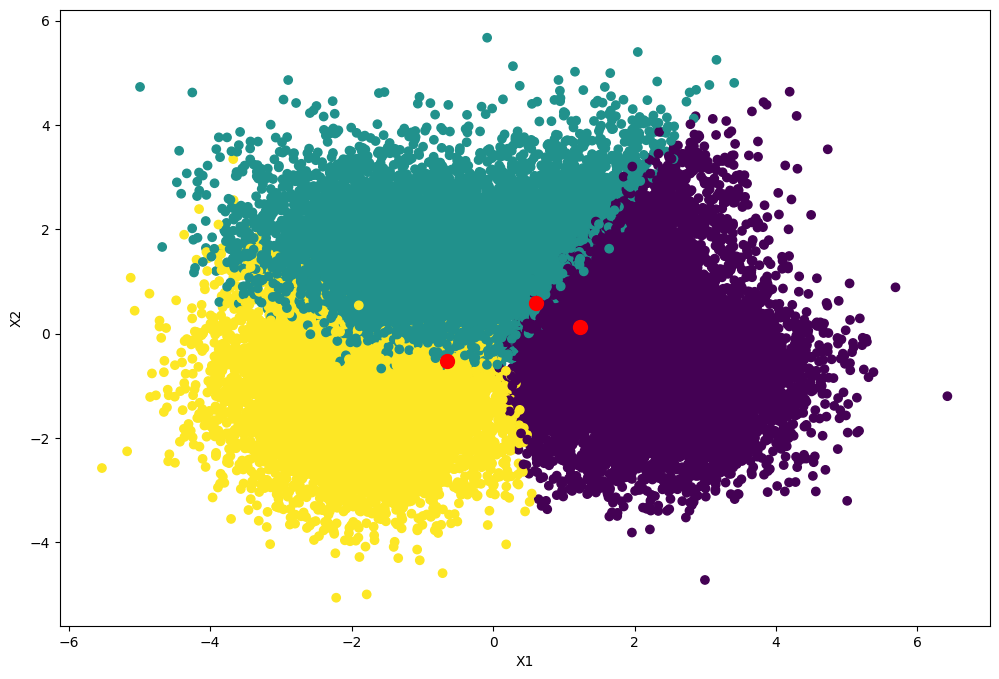

In [24]:
from sklearn.decomposition import PCA

# Crear el modelo
pca = PCA(n_components=2)

# Entrenar el modelo
pca.fit(X)

# Transformar los datos
X_pca = pca.transform(X)

# Graficar los clusters con centroides y con nombre de los clusters
plt.figure(figsize=(12, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=100)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

### Optimizacion de parametros para mejorar resultados

**Aplicamos Standar scaler a los datos**

In [28]:
# Aplicamos standard scaler
from sklearn.preprocessing import StandardScaler

# Preparar los datos
X = df_vector

# Crear el modelo
scaler = StandardScaler()

# Entrenar el modelo
scaler.fit(X)

# Transformar los datos
X_scaled = scaler.transform(X)

# Visualizamos los datos como dataframe
df_scaled = pd.DataFrame(X_scaled)
df_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,3.293246,-0.200550,-2.476247,-0.739688,-0.023093,-0.456389,-0.259089,0.914196,0.371441,0.211644,1.154833,1.448040,-0.297035,0.374104,-0.153762,0.253504,-0.931633,0.459412,-0.295488,1.222586
1,1.528508,-2.252650,-1.441493,-0.699722,1.867350,-0.393552,0.607108,-0.770098,-1.301926,-1.757261,1.291567,0.019323,-1.685916,-1.964470,-0.603148,0.707609,-0.892234,-2.854508,-0.025828,-0.059757
2,-0.066362,-0.803744,0.058264,-3.164715,0.593561,-1.454222,1.305222,1.567343,0.103788,-0.460863,-1.760727,-0.333684,0.893335,-1.338977,-0.631052,0.321780,0.047917,-0.964871,-0.402647,-1.800638
3,0.685098,-1.988037,-2.136767,-2.510784,-1.109061,1.774069,0.522432,2.479569,-1.112363,1.871105,-1.024584,1.912695,-2.398043,0.472782,-2.259240,0.163855,-2.303168,-0.655617,-0.194212,-2.435145
4,2.344291,1.186233,-0.903517,-1.793055,-1.058301,-0.232973,-0.840243,-1.642701,-0.191102,-0.703004,0.937812,-0.260566,-1.655931,0.418491,1.195602,-0.705892,-0.689422,0.450038,0.454629,-0.981322


**Seleccion de caracteristicas con random forest**

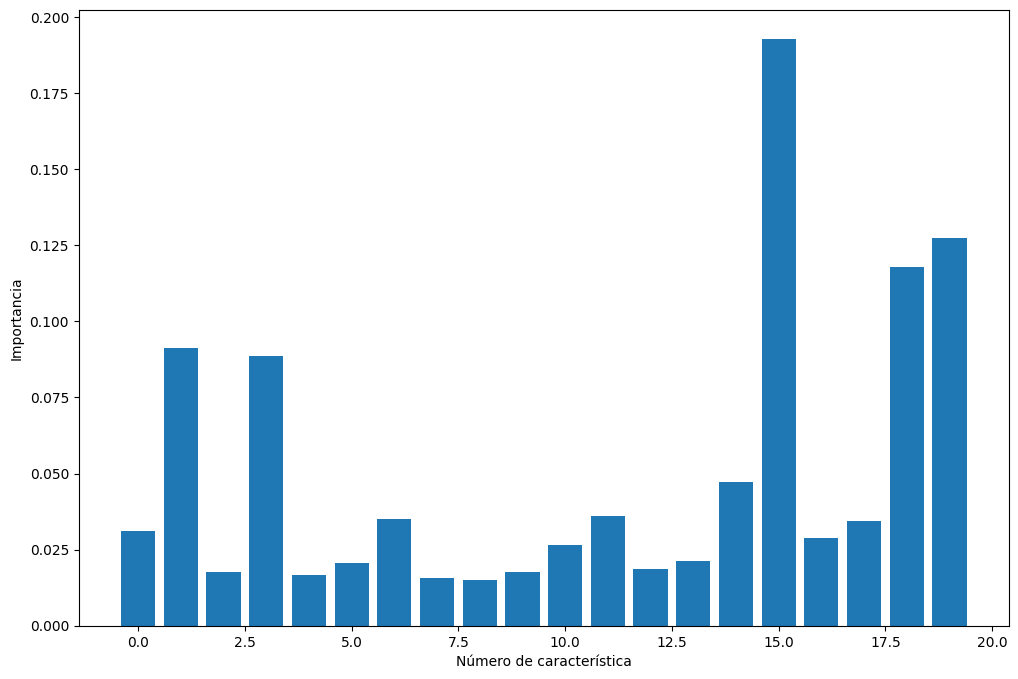

In [15]:
# Seleccion de características con random forest
from sklearn.ensemble import RandomForestClassifier

# Preparar los datos
y = df['Attraction'].copy()

# Crear el modelo
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf.fit(X_scaled, y)
# Extraer las importancias de las características
importances = rf.feature_importances_

# Graficar las importancias de las características
plt.figure(figsize=(12, 8))
plt.bar(range(len(importances)), importances)
plt.xlabel('Número de característica')
plt.ylabel('Importancia')
plt.show()

**Seleccionamos las 15 mejores caracteristicas**

In [16]:
df_vector_important_features = df_vector.iloc[:, importances.argsort()[::-1][:15]]

# Mostrar el dataframe
df_vector_important_features.head()

,V15,V19,V18,V1,V3,V14,V11,V6,V17,V0,V16,V10,V13,V5,V12
0,0.692752,0.341731,-0.814182,-0.209575,-0.162088,0.191621,1.867570,-0.063966,0.450602,4.900025,0.259654,2.002495,0.640072,-0.435943,-0.849307
1,1.264505,-1.090011,-0.491314,-2.724005,-0.114774,-0.319622,0.179084,0.864899,-3.727610,2.456350,0.308560,2.152327,-1.930827,-0.361509,-2.445225
2,0.778716,-3.033712,-0.942485,-0.948667,-3.032995,-0.351367,-0.238107,1.613521,-1.345143,0.247894,1.475597,-1.192362,-1.243195,-1.617944,0.518507
3,0.579877,-3.742143,-0.692923,-2.399776,-2.258828,-2.203670,2.416708,0.774097,-0.955233,1.288459,-1.442873,-0.385700,0.748553,2.206184,-3.263507
4,-0.515201,-2.118943,0.083946,1.489644,-1.409133,1.726721,-0.151695,-0.687166,0.438784,3.585984,0.560317,1.764684,0.688868,-0.171292,-2.410770


**Entrenar el modelo con esta configuracion de caracteristicas**

In [17]:
# Prepapar los datos
X_best = df_vector_important_features

# Crear el modelo
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# Entrenar el modelo
kmeans.fit(X_best)

KMeans(n_clusters=3, n_init=10, random_state=42)

**Evaluar resultados**

In [18]:
ymeans_best = kmeans.labels_

print("El índice de silueta es: ", silhouette_score(X_best, ymeans_best))
print("La puntuación de Calinski-Harabasz es: ", calinski_harabasz_score(X_best, ymeans_best))

El índice de silueta es:  0.10862058
La puntuación de Calinski-Harabasz es:  3653.0819165044113


**Graficar**

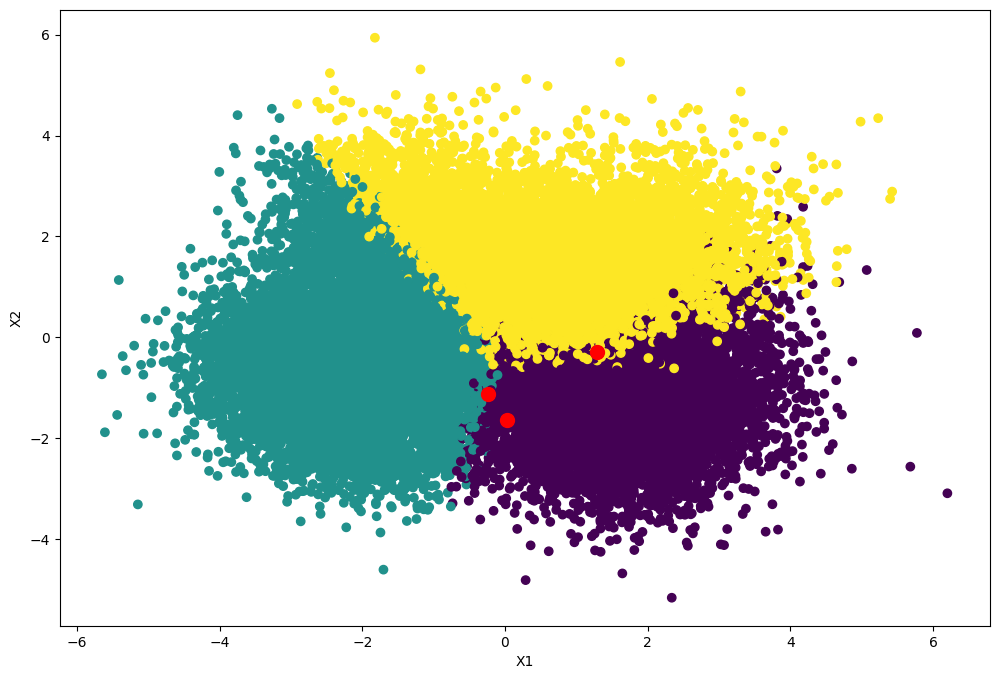

In [19]:
from sklearn.decomposition import PCA

# Crear el modelo
pca = PCA(n_components=2)

# Entrenar el modelo
pca.fit(X_best)

# Transformar los datos
X_pca_best = pca.transform(X_best)

# Graficar los clusters con centroides
plt.figure(figsize=(12, 8))
plt.scatter(X_pca_best[:, 0], X_pca_best[:, 1], c=ymeans_best, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=100)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()